### Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import collections
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import multilabel_confusion_matrix
#import keras
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
#from keras.utils import to_categorical
#from keras.preprocessing import image

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

import PIL
from copy import deepcopy

### Loading in data, train and test sets

In [2]:
#train = pd.read_csv("data/train.csv")
#test_data = pd.read_csv("data/test.csv")
#labels_data = pd.read_csv("data/labels.csv")

In [3]:
#train

# FastAI

In [ ]:
#!pip install fastai==1.0.61

In [ ]:
#!pip install fastai --upgrade

In [4]:
from fastai.vision.all import *

In [ ]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
block = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_x=ColReader(0, pref="./data/images/"),
                 splitter=RandomSplitter(),
                 get_y=ColReader(1, label_delim=" "),
                 batch_tfms = batch_tfms)

In [ ]:
block = block.new(item_tfms=Resize(400, ResizeMethod.Pad, pad_mode="zeros"))

In [ ]:
dls = block.dataloaders(train_less_labels)

In [ ]:
dls.show_batch(max_n=9, figsize=(10, 10))

In [ ]:
from torchvision.models import resnet34

In [ ]:
from fastai.metrics import accuracy_multi

In [ ]:
learn = vision_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-3
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

In [ ]:
learn.show_results(figsize=(15,15))

In [ ]:
learn.save('stage-2')

img288 missing, img285 missing

In [ ]:
#batch_tfms = aug_transforms(size=300)
block = DataBlock(blocks=(ImageBlock),
                 get_x=ColReader(0, pref="./data/images/"))
block = block.new(item_tfms=Resize(400, ResizeMethod.Pad, pad_mode="zeros"))
dls = block.dataloaders(test_data)
dls.show_batch(max_n=9, figsize=(10, 10))


In [ ]:
#dl = learn.dls.test_dl(test_data, bs=64)
#preds, _ = learn.get_preds(dl= dls)
print(learn.dls.vocab)
print(learn.dls.c)
min_probability = 0.79
filenames = []
predictions = []
for image_name in test_data["image_id"]:
    #print(image_name)
    pred = learn.predict("./data/images/"+image_name)
    #print(pred)
    pred_labels = pred[0]
    preds = pred[2]
    ind = np.argpartition(preds, -5)[-5:]
    #print(ind)
    ind = ind.tolist()
    best_preds_labels = learn.dls.vocab[ind]
    #print(best_preds_labels)
    probabilities = preds[ind]
    #print(probabilities)
    final_labels = []
    for i, proba in enumerate(probabilities):
        if proba > min_probability:
            final_labels.append(best_preds[i])
    #print(final_labels)
    final_labels.reverse()
    #print(final_labels)
    
    #print("CSVsse", image_name, " ".join(final_labels))
    filenames.append(image_name)
    predictions.append(" ".join(final_labels))
    #print(len(preds), len(pred_labels))

In [ ]:
print(filenames)
print(predictions)

In [ ]:
d = {"image_id": filenames, "labels": predictions}
df = pd.DataFrame(d, columns=["image_id", "labels"])

In [ ]:
df

In [ ]:
df.to_csv("submission.csv", index=False)

Another method. https://www.kaggle.com/code/thedrcat/oversampling-for-multi-label-classification/notebook

In [5]:
train_os_w_ratios = pd.read_pickle("./data/processed/train_oversample_w_ratios.pkl")
test_data = pd.read_pickle("./data/processed/test_cleaned.pkl")

In [6]:
# item_tfms = RandomResizedCrop(1000, min_scale=0.75, ratio=(1.,1.)) - original
item_tfms = Resize(500, ResizeMethod.Pad, pad_mode="zeros") #Resize(400, ResizeMethod.Pad, pad_mode="zeros")
batch_tfms = [*aug_transforms(max_warp=0, max_rotate=0, max_lighting=0.1)] # add normalize?

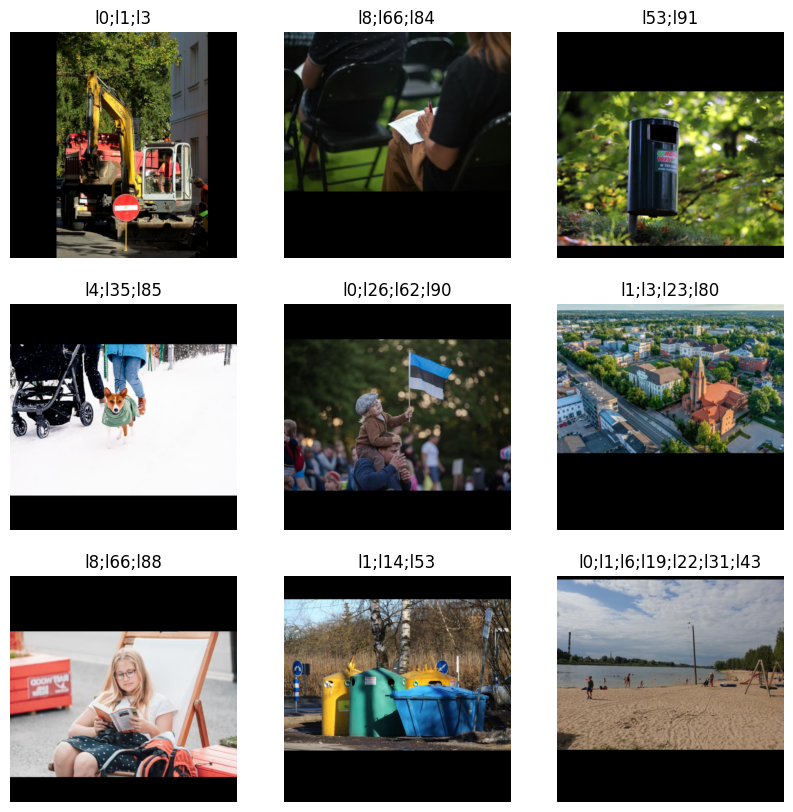

In [7]:
labels = ["l"+str(i) for i in range(92)]
#first 5 FastAI: splitter = RandomSplitter()
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),
                   splitter=RandomSplitter(), # TrainTestSplitter(),
                   get_x=ColReader(0, pref="./data/images/"),
                   get_y=ColReader(1, label_delim=" "),
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms,
                   )
bs=32
dls = dblock.dataloaders(train_os_w_ratios, bs=bs)

dls.show_batch(max_n=9, figsize=(10, 10))

In [8]:
epochs = 30
lr = 1e-3
cbs= None
learn = cnn_learner(dls, resnet18, metrics=[accuracy_multi, APScoreMulti(), F1ScoreMulti(average="macro"), 
                                            F1ScoreMulti(average="micro")]).to_fp16()
learn.fine_tune(epochs, base_lr=lr, cbs=cbs)

C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.war

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,f1_score,time
0,1.056116,0.818732,0.500198,0.110169,0.089479,0.096463,02:35


C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\Taaniel\Documents\Co

epoch,train_loss,valid_loss,accuracy_multi,average_precision_score,f1_score,f1_score,time
0,1.017269,0.789085,0.524407,0.128633,0.095649,0.106553,03:14
1,1.004591,0.788736,0.528459,0.156989,0.108003,0.118907,03:13


C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\sklearn\metrics\_ra

KeyboardInterrupt: 

In [ ]:
learn.save('newFastAI_30epoch_crop500')

In [9]:
#dl = learn.dls.test_dl(test_data, bs=64)
#preds, _ = learn.get_preds(dl= dls)
print(learn.dls.vocab)
print(learn.dls.c)
min_probability = 0.0
filenames = []
predictions = []
for image_name in test_data["image_id"]:
    #print(image_name)
    pred = learn.predict("./data/images/"+image_name)
    #print(pred)
    pred_labels = pred[0]
    preds = pred[2]
    ind = np.argpartition(preds, -5)[-5:]
    #print(ind)
    ind = ind.tolist()
    best_preds_labels = learn.dls.vocab[ind]
    #print(best_preds_labels)
    probabilities = preds[ind]
    #print(probabilities)
    final_labels = []
    for i, proba in enumerate(probabilities):
        if proba > min_probability:
            final_labels.append(best_preds_labels[i])
    #print(final_labels)
    final_labels.reverse()
    #print(final_labels)
    
    #print("CSVsse", image_name, " ".join(final_labels))
    filenames.append(image_name)
    predictions.append(" ".join(final_labels))
    #print(len(preds), len(pred_labels))

['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9', 'l10', 'l11', 'l12', 'l13', 'l14', 'l15', 'l16', 'l17', 'l18', 'l19', 'l20', 'l21', 'l22', 'l23', 'l24', 'l25', 'l26', 'l27', 'l28', 'l29', 'l30', 'l31', 'l32', 'l33', 'l34', 'l35', 'l36', 'l37', 'l38', 'l39', 'l40', 'l41', 'l42', 'l43', 'l44', 'l45', 'l46', 'l47', 'l48', 'l49', 'l50', 'l51', 'l52', 'l53', 'l54', 'l55', 'l56', 'l57', 'l58', 'l59', 'l60', 'l61', 'l62', 'l63', 'l64', 'l65', 'l66', 'l67', 'l68', 'l69', 'l70', 'l71', 'l72', 'l73', 'l74', 'l75', 'l76', 'l77', 'l78', 'l79', 'l80', 'l81', 'l82', 'l83', 'l84', 'l85', 'l86', 'l87', 'l88', 'l89', 'l90', 'l91']
92


C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\Taaniel\Documents\Courses\ML\project\ML_2022_project\venv\lib\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [10]:
for i in range(len(filenames)):
    print(filenames[i], predictions[i])

img102.jpg l26 l75 l49 l12 l41
img103.jpg l1 l39 l41 l68 l49
img11.jpg l0 l62 l52 l39 l34
img113.jpg l14 l91 l77 l17 l49
img114.jpg l86 l48 l76 l77 l46
img121.jpg l41 l56 l88 l81 l27
img126.jpg l70 l49 l75 l47 l53
img131.jpg l40 l67 l69 l53 l78
img136.jpg l75 l28 l14 l52 l53
img137.jpg l32 l79 l1 l77 l75
img139.jpg l20 l49 l85 l48 l33
img140.jpg l22 l23 l34 l43 l63
img15.jpg l71 l43 l15 l81 l9
img150.jpg l0 l62 l26 l51 l1
img151.jpg l0 l59 l77 l71 l44
img152.jpg l65 l3 l22 l13 l2
img156.jpg l0 l5 l76 l40 l3
img161.jpg l45 l43 l54 l16 l77
img166.jpg l1 l54 l22 l27 l7
img167.jpg l49 l53 l89 l52 l74
img170.jpg l33 l75 l19 l44 l49
img173.jpg l66 l79 l42 l67 l85
img176.jpg l57 l22 l18 l52 l87
img18.jpg l68 l72 l87 l36 l2
img180.jpg l80 l31 l30 l68 l79
img181.jpg l33 l36 l23 l82 l40
img182.jpg l23 l6 l52 l10 l31
img183.jpg l26 l49 l44 l20 l74
img189.jpg l20 l69 l75 l51 l6
img192.jpg l64 l90 l12 l71 l5
img194.jpg l1 l62 l53 l44 l33
img195.jpg l24 l14 l0 l21 l57
img206.jpg l0 l36 l8 l17 l80
im

In [11]:
d = {"image_id": filenames, "labels": predictions}
df = pd.DataFrame(d, columns=["image_id", "labels"])

In [12]:
df.to_csv("submission_e50_crop500.csv", index=False)